In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
import pyForwardFolding as pyFF
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from math import inf

In [23]:
n_events = int(1E6)

atmo_norm = 1E4
astro_norm = 1E3

livetime = np.pi * 1E7

astro_spectrum = sp.stats.pareto(1, scale=1E2)
atmo_spectrum = sp.stats.pareto(2, scale=1E2)



In [24]:
event_energies = 10**np.random.uniform(2, 8, size=n_events)

reco_energy = 10**(np.log10(event_energies) + np.random.normal(0, 0.2, size=n_events))
gen_norm = 1/ (1E8 - 1E2)

baseline_weights = gen_norm * np.ones(n_events)

astro_weights = astro_norm * astro_spectrum.pdf(event_energies) * baseline_weights
atmo_weights = atmo_norm * atmo_spectrum.pdf(event_energies) * baseline_weights

data = {"det1": {
    "reco_energy": jnp.asarray(reco_energy),
    "baseline_weights": jnp.asarray(baseline_weights),
    "true_energy": jnp.asarray(event_energies),
    "atmo_weights": jnp.asarray(atmo_weights),
}}


(0.01, 1000000.0)

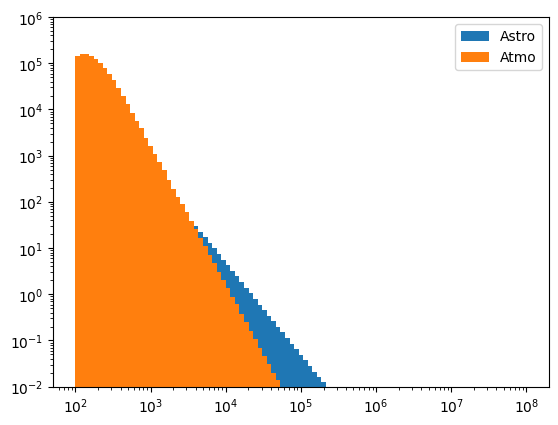

In [25]:
fig, ax = plt.subplots()
h = ax.hist(reco_energy, bins=np.logspace(2, 8, 100), weights=astro_weights * livetime, label="Astro")
h = ax.hist(reco_energy, bins=np.logspace(2, 8, 100), weights=atmo_weights * livetime, label="Atmo")
plt.legend()
plt.loglog()
ax.set_ylim(1E-2, 1E6)


In [45]:
powerlaw_factor = pyFF.factor.PowerLawFlux("astro_norm", 1E5, 1E-6, {"flux_norm": "astro_norm", "spectral_index": "astro_index"})
atmo_norm_factor = pyFF.factor.FluxNorm("atmo_norm", {"flux_norm": "atmo_norm"})
astro_comp = pyFF.model_component.ModelComponent("astro", [powerlaw_factor])
atmo_comp = pyFF.model_component.ModelComponent("atmo", [atmo_norm_factor])
model = pyFF.model.Model("model", [astro_comp, atmo_comp], ["baseline_weights", "atmo_weights"])

ebins = np.logspace(2, 4.5, 50)

binning = pyFF.binning.RectangularBinning(("reco_energy", ), (ebins, ))

binned_expectation = pyFF.binned_expectation.BinnedExpectation("hist1", [("det1", model)], binning, lifetime=livetime)

analysis = pyFF.analysis.Analysis({"hist1": binned_expectation})


priors = [
    pyFF.likelihood.UniformPrior(
        {"astro_norm": 3,
         "astro_index": 2,
         "atmo_norm": 1},
         {"astro_norm": (0, 6),
          "astro_index": (1, 4),
          "atmo_norm": (0, inf)}
    )
]

llh = pyFF.likelihood.PoissonLikelihood(analysis,priors)

h0 = pyFF.statistics.Hypothesis("h0", llh, {"astro_norm": 0})
h1 = pyFF.statistics.Hypothesis("h1", llh)
lhrt = pyFF.statistics.HypothesisTest(h0, h1, data)


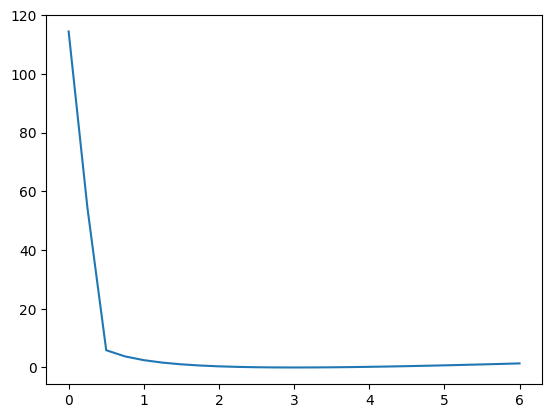

In [46]:
obs = h1.asimov_experiment(data)
lhr_scan = lhrt.scan(obs, 25)
plt.plot(lhr_scan[0], lhr_scan[1])


[]

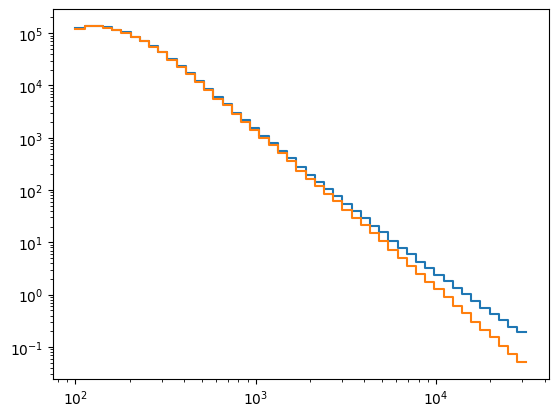

In [48]:
parameter_values = {"astro_norm": 3., "astro_index": 2., "atmo_norm": 1.}
ana_eval, _ = analysis.evaluate(data, parameter_values)

plt.step(ebins, np.append(ana_eval["hist1"],ana_eval["hist1"][-1]), where="post")

parameter_values = {"astro_norm": 0., "astro_index": 2., "atmo_norm": 1.}
ana_eval, _ = analysis.evaluate(data, parameter_values)

plt.step(ebins, np.append(ana_eval["hist1"],ana_eval["hist1"][-1]), where="post")
plt.loglog()

In [49]:
parameter_values = {"astro_norm": 3., "astro_index": 2., "atmo_norm": 1.}
analysis.variance(data, parameter_values)

{'astro_norm': Array(3.54534766, dtype=float64),
 'astro_index': Array(0.01983282, dtype=float64),
 'atmo_norm': Array(4.91792377e-05, dtype=float64)}

In [50]:
lhrt.uncertainty(obs, 1)

1.9486457737139817

In [51]:
np.sqrt(3.54534766)

np.float64(1.8829093605375697)

In [ ]:
np.sqrt(174)

np.float64(13.19090595827292)

In [ ]:
lhrt.discovery_potential_asimov(2)

Evaluating hypothesis:  h0  with fixed parameters:  {'astro_norm': 0}
Evaluating hypothesis:  h1  with fixed parameters:  {}
Evaluating hypothesis:  h0  with fixed parameters:  {'astro_norm': 0}
Evaluating hypothesis:  h1  with fixed parameters:  {}


ValueError: f(a) and f(b) must have different signs

In [ ]:
asimov_exp = h1.asimov_experiment(data, {"astro_norm": 2})
lhrt.test(asimov_exp)

Evaluating hypothesis:  h0  with fixed parameters:  {'astro_norm': 0}
Evaluating hypothesis:  h1  with fixed parameters:  {}


0.5477586859152552

In [ ]:
h0.evaluate(asimov_exp, data)

Evaluating hypothesis:  h0  with fixed parameters:  {'astro_norm': 0}


119.60015444258619

In [ ]:
h0.evaluate(asimov_exp, data, {"astro_norm": 2})

Evaluating hypothesis:  h0  with fixed parameters:  {'astro_norm': 2, 'astro_index': 2, 'atmo_norm': 1}


Array(119.3262751, dtype=float64)

In [ ]:
h0.fixed_pars

{'astro_norm': 0}